# Solving Differential equations in Julia

In this notebook I will go over some of the basics of solving ordinary differential equations (ODEs) numerically using ```julia```. I will demonstrate how to integrate differential equations using two approaches:

1. Implement a solution method, like the [Euler method](https://en.wikipedia.org/wiki/Euler_method), in a DIY (Do It Yourself!) way.

2. Solve using the functions in the julia package [```DifferentialEquations.jl```](http://docs.juliadiffeq.org/latest/).


To run this notebook you will need the following packages:

- To plot the results: ```Plots.jl``` and```PyPlot.jl```. Also ```LaTeXStrings.jl``` to be able to use LaTeX in the labels of the figures. 
- Labelled arrays (which  I explain later) ```LabelledArrays```.
- To use the differential equations functions ```DiffEqCallbacks.jl``` and ```DifferentialEquations.jl```



In [43]:
using Plots; pyplot();
using LaTeXStrings;
using Printf;
using BenchmarkTools;

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


To illustrate the two different solution approaches I will use the example of the [Lotka-Volterra](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) model.

#### Lotka-Volterra equations

The Lotka-Volterra equations are a simple mathematical model that it is used the predict the evolution of the population of 2 species which interact: one as preadator an the other one as prey. The mathematical model is a pair of first-order nonlinear differential equations for the variables $x$, and $y$ which stand for the population of preys and predators. The instantaneous rate of growth of each species is given by

\begin{equation}
    \begin{split}
        \frac{dx}{dt} &= x\;(\alpha - \beta y)
        \\
        \frac{dy}{dt} &= y\;(\gamma x - \delta)
    \end{split}
\end{equation}

$\alpha,\beta,\gamma,\delta$ are real positive parameters describing the interaction between both species (Their physical meaning is discussed [here](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)).

# Overview of the 2 methods

I will focus on ODEs systems of first degree, which have normally the form $\frac{d}{dt}X(t) = f(X(t),P,t)$, where $X(t) = \left( X_1(t),X_2(t),...,X_N(t)\right)^\mathsf{T}$ is the vector containing the $N$ independent variables, $P=\left( P_1,P_2,...,P_M\right)^\mathsf{T}$ is a vector containing all $M$ parameters the problem depends on, and $t$ is time. $f(X(t),P,t)$ is an $N$-dimensional vector function that gives the evoliution of the components of $X$, $\frac{d}{dt}X_i(t) = f_i(X(t),P,t)$. This kind of system is pretty general, because even if we have a system of equations of higher degree we can alaways reduce it to first degree.

In the model we are using we have $X(t) = \left( x(t),y(t) \right)^\mathsf{T}$, $P =\left( \alpha,\beta,\gamma,\delta \right)^\mathsf{T}$ and 

\begin{equation}
    f(X,P,t) = 
    \Bigg(
    \begin{array}{c}
        x\;(\alpha - \beta y)
        \\
        y\;(\gamma x - \delta)
    \end{array}
    \Bigg)
\end{equation}



#### Solution with DIY solver

In this section I consider the [Euler method](https://en.wikipedia.org/wiki/Euler_method) for its simplicity, the same philosophy can be applied to other methods.

The Euler method consists in discretizing the time variable in small intervals 

```pseudocode
x_[i+1] = x_[i] + f(x_[i]),P,t_[i]) * (t_[i+1]-t_[i])
```

#### Solution with ```DifferentialEquations.jl```

The work-flow with this package consists in first defining a ```ODEProblem``` object from the initial conditions and the function  $f(X(t),P,t)$. Then, one calls the solve function to integrate the equation for the given times. 


# Solution with ```DifferentialEquations.jl```

Now, the steps to solve the equation

#### 1. Import the necessary packages

In [11]:
using DifferentialEquations;
using LabelledArrays;

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling LabelledArrays [2ee39098-c373-598a-b85f-a56591580800]
└ @ Base loading.jl:1273


#### 2. Defining the $f(X(t),P,t)$ function

This can be done the two different forms. We can either define a function that returns the value of the derivative

In [2]:
function f_LV(X,P,t)
    return [
            X[1] * (P.α - P.β * X[2]),
            -X[2] * (P.γ - P.δ * X[1])
    ];
end;

or defining a function that changes the values of a preallocated array ```dX``` which contains the derivatives of the dependent variables.

In [3]:
function f_LV!(dX,X,P,t)
    dX[1] = X[1] * (P.α - P.β * X[2]);
    dX[2] = -X[2] * (P.γ - P.δ * X[1]);
end;

The latter kind of function (the ones that change the state if its arguments) is known as a **mutating function** in julia. It is more efficient to define the derivative with a mutating function since changing the values of already allocated arrays is faster than allocating new arrays. Allocating memory for arrays is expensive when done repeatedly. See the results of the folowing performance test of both functions. 

In [15]:
dX = rand(2);
X = rand(2);
P = LVector(α =4. , β=1. , γ = 4. , δ = 1.);
t = 0.;

Test ```f_LV```

In [25]:
@benchmark f_LV(X,P,t)

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  1
  --------------
  minimum time:     40.256 ns (0.00% GC)
  median time:      44.993 ns (0.00% GC)
  mean time:        49.778 ns (8.22% GC)
  maximum time:     2.215 μs (97.32% GC)
  --------------
  samples:          10000
  evals/sample:     991

Test ```f_LV!``` 

In [27]:
@benchmark f_LV!(dX,X,P,t)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     22.596 ns (0.00% GC)
  median time:      25.493 ns (0.00% GC)
  mean time:        26.122 ns (1.63% GC)
  maximum time:     1.461 μs (98.16% GC)
  --------------
  samples:          10000
  evals/sample:     996

Comparing the results of both tests we see that the mutating function consumes less resources (memory) and is almost twices as fast. When doing benchmarks, is usually more informative to check the median time since is less biased by the outliers in the sample, i.e., exceptionally large or small times

#### 3. Defining the problem object

Here, we will defined what is called a ```ODEProblem``` *object*, which contains all the relevant information of our problem. The basic pieces we need to construct the problem are

- The function $f(dX,X,P,t)$ that update the value of the derivative with respect time.
- The initial conditions
- The time span
- The parameters


**Initial condition**

In [34]:
u0_LV = [1.,1.]

2-element Array{Float64,1}:
 1.0
 1.0

**Time span**

In [35]:
T_Final_LV = 10.              #Final time
tspan_LV = (0.0,T_Final_LV);  #From 0 to T_Final_LV

**Parameters**

They are put inside a [Labelled vector](https://github.com/JuliaDiffEq/LabelledArrays.jl). This kind of arrays allow accesing to the elements by their name ```LabelledarrayName.elementName```.

In [36]:
P_LV = LVector(α =4. , β=1. , γ = 4. , δ = 1.);

println(P_LV.α,)

4.0


**Construct the problem object**

In [39]:
problem_LV = ODEProblem(f_LV!,u0_LV,tspan_LV,P_LV)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

#### 4. Solve the problem by calling the function ```solve``` from the DifferentialEquations Package.

In [41]:
sol_LV = solve(problem_LV)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 70-element Array{Float64,1}:
  0.0                
  0.06084855858191972
  0.17081664347724562
  0.28690035693517885
  0.4295177475208707 
  0.6053539350149165 
  0.7725940620742761 
  0.8921014499734694 
  0.9949721204630707 
  1.103132779271137  
  1.198319187050117  
  1.2924131485440091 
  1.4268754445976708 
  ⋮                  
  8.524602142470581  
  8.61389580634974   
  8.701816690462776  
  8.808544683099631  
  8.909011553060688  
  9.006502151050729  
  9.125704603349241  
  9.250689422790861  
  9.415974725012381  
  9.594212764287223  
  9.799800927528949  
 10.0                
u: 70-element Array{Array{Float64,1},1}:
 [1.0, 1.0]                              
 [1.2064374465005956, 0.8381853116209412]
 [1.7290117538796257, 0.633178941979179] 
 [2.576362455225402, 0.5091573843408783] 
 [4.258353286776334, 0.46377496247594024]
 [7.849430636440425, 0.6461910344584615] 
 [12.81411583846938, 1.85187604

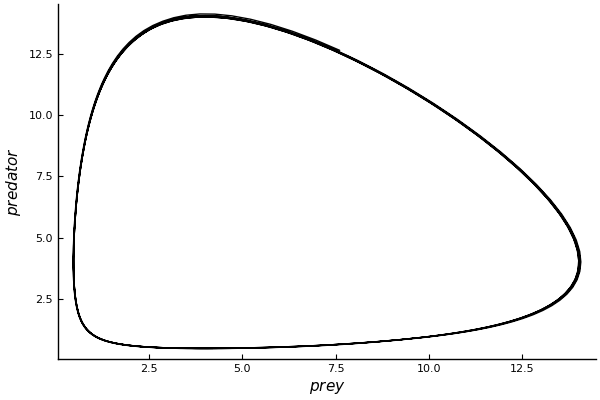

In [45]:
plotPhase_LV = plot(
    grid = false
    ,legend = false
    ,xlabel = latexstring("prey")
    ,ylabel = latexstring("predator")
)

plotΔt_LV = 0.01;

plot!(
        [sol_LV(t)[1] for t in 1:plotΔt_LV:T_Final_LV],[sol_LV(t)[2] for t in 1:plotΔt_LV:T_Final_LV]
        ,color=:black
    )


plotPhase_LV

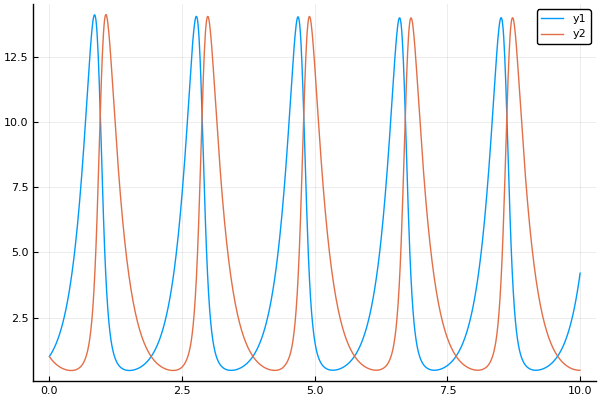

In [57]:
tt = 0:0.01:T_Final_LV
plot(
    tt,[sol_LV(t)[1] for t in tt]
    )
plot!(
    tt,[sol_LV(t)[2] for t in tt]
    )